## Imports

In [3]:
!pip install scikeras
!pip install pandas
!pip install matplotlib
!pip install statsmodels
!pip install opencv-python
!pip install keras-tuner

/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found


In [1]:
import os
import cv2
import json
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import CSVLogger

In [2]:
# Check GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Configure TensorFlow to use the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2024-11-01 06:05:19.412221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 06:05:19.447697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 06:05:19.449388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Step 1: Create dataset (train, test, val)

In [3]:
def create_datasets(base_dir="../data"):
    # Separate lists for each dataset
    train_data = []
    val_data = []
    test_data = []

    # Define the folders and subfolders to iterate through
    for folder in ['train', 'validation', 'test']:
        for subfolder in ['real', 'deepfake']:
            subfolder_path = os.path.join(base_dir, folder, subfolder)

            # Check if the subfolder exists
            if not os.path.exists(subfolder_path):
                print(f"Subfolder {subfolder_path} does not exist.")
                continue

            # Loop through each subdirectory (representing each video) in the subfolder
            for video_dir in os.listdir(subfolder_path):
                video_path = os.path.join(subfolder_path, video_dir)

                # Ensure the path is a directory (each video is in a subdirectory)
                if os.path.isdir(video_path):
                    # Create a label based on the subfolder
                    label = 1 if subfolder == 'deepfake' else 0

                    # Loop through each frame in the video directory
                    for frame_file in os.listdir(video_path):
                        frame_path = os.path.join(video_path, frame_file)

                        # Check if the file is an image
                        if frame_file.endswith(('.jpg', '.png', '.jpeg')) and os.path.isfile(frame_path):
                            # Append the frame path and label to the appropriate dataset list
                            if folder == 'train':
                                train_data.append({'file_path': frame_path, 'label': label})
                            elif folder == 'validation':
                                val_data.append({'file_path': frame_path, 'label': label})
                            elif folder == 'test':
                                test_data.append({'file_path': frame_path, 'label': label})

    # Create DataFrames from the collected data
    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)

    # Shuffle the DataFrames
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return train_df, val_df, test_df

In [4]:
train_df, val_df, test_df = create_datasets()

In [5]:
test_df

,file_path,label
0,../data/test/deepfake/gycrbqqnje/frame_0200.jpg,1
1,../data/test/deepfake/whfdwsqmrt/frame_0219.jpg,1
2,../data/test/real/rkqwwxjduw/frame_0009.jpg,0
3,../data/test/deepfake/tkpnnjqryo/frame_0048.jpg,1
4,../data/test/deepfake/okfinkhovh/frame_0038.jpg,1
...,...,...
326059,../data/test/real/qohooxdwvh/frame_0020.jpg,0
326060,../data/test/deepfake/olpoagoucj/frame_0292.jpg,1
326061,../data/test/real/ystdtnetgj/frame_0122.jpg,0
326062,../data/test/real/mlfbccdtoy/frame_0153.jpg,0


## Step 2: Preprocessing

In [6]:
def load_and_preprocess_image(file_path):
    # Load the image from the file path
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image
    image = tf.image.resize(image, [224, 224])  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    return image

def create_tf_dataset(df, batch_size=32, shuffle=True):
    # Create a tf.data.Dataset from the DataFrame
    file_paths = df['file_path'].values
    labels = df['label'].values

    # Create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Map the loading and preprocessing function
    dataset = dataset.map(
        lambda file_path, label: (load_and_preprocess_image(file_path), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Shuffle and batch the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance

    return dataset

In [12]:
# Parameters
batch_size = 64

# Create datasets
train_dataset = create_tf_dataset(train_df, batch_size=batch_size)
validation_dataset = create_tf_dataset(val_df, batch_size=batch_size)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Step 3: Build CNN Model

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32),
                     (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64),
                     (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0.3, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Step 4: Training

In [ ]:
# Set up the tuner
csv_logger = CSVLogger('training_output.csv', append=True)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_tuning',
)
# Start tuning
tuner.search(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[csv_logger])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |filters_1
192               |192               |filters_2
64                |64                |units
0.4               |0.4               |dropout
0.0001            |0.0001            |learning_rate

Epoch 1/10


2024-10-31 12:24:40.144872: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


16599/16599 [==============================] - 4495s 270ms/step - loss: 0.4690 - accuracy: 0.7642 - val_loss: 0.4797 - val_accuracy: 0.7815
Epoch 2/10
 4227/16599 [======>.......................] - ETA: 52:08 - loss: 0.3516 - accuracy: 0.8381

In [14]:
# 1. Save the best model
best_model.save("best_cnn_model.h5")  # Saves the model as an H5 file

# 2. Print the model summary
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    47,775,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,927,169 (182.83 MB)

 Trainable params: 47,927,169 (182.83 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Predictions

In [7]:
# Load the saved model
best_model_loaded = load_model("best_cnn_model.h5")

In [8]:
def predict_videos(model, test_df, batch_size=32):
    # Dictionary to store video predictions and labels
    video_predictions = {}
    all_predictions = []
    all_true_labels = []

    # Lists to store images and labels in each batch
    batch_images = []
    batch_true_labels = []
    video_dirs = []

    # Counter to track number of predictions
    prediction_count = 0

    for index, row in test_df.iterrows():
        frame_path = row['file_path']
        video_dir = os.path.dirname(frame_path)  # Get the directory of the video
        true_label = row['label']  # Retrieve the true label for this frame

        # Load and preprocess the image
        image = load_and_preprocess_image(frame_path)
        batch_images.append(image)
        batch_true_labels.append(true_label)
        video_dirs.append(video_dir)

        # Once batch is filled, predict and process results
        if len(batch_images) == batch_size:
            # Stack images in the batch along the first dimension
            batch_images = np.stack(batch_images)
            # Predict on the batch
            batch_predictions = model.predict(batch_images, verbose=0).flatten()

            # Process predictions
            for i, prediction_value in enumerate(batch_predictions):
                video_dir = video_dirs[i]
                true_label = batch_true_labels[i]

                if video_dir not in video_predictions:
                    video_predictions[video_dir] = {
                        'predictions': [],
                        'true_labels': true_label  # Store the true label
                    }
                video_predictions[video_dir]['predictions'].append(prediction_value)
                all_predictions.append(prediction_value)
                all_true_labels.append(true_label)
                prediction_count += 1

            # Print progress every 10,000 predictions
            if prediction_count % 10000 == 0:
                print(f"{prediction_count} predictions processed.")

            # Clear batch data for next set
            batch_images, batch_true_labels, video_dirs = [], [], []

    # Predict any remaining images that didn’t fill the last batch
    if batch_images:
        batch_images = np.stack(batch_images)
        batch_predictions = model.predict(batch_images, verbose=0).flatten()
        for i, prediction_value in enumerate(batch_predictions):
            video_dir = video_dirs[i]
            true_label = batch_true_labels[i]
            if video_dir not in video_predictions:
                video_predictions[video_dir] = {
                    'predictions': [],
                    'true_labels': true_label
                }
            video_predictions[video_dir]['predictions'].append(prediction_value)
            all_predictions.append(prediction_value)
            all_true_labels.append(true_label)
            prediction_count += 1

    # Aggregate predictions at the video level
    video_classifications = {}
    for video_dir, data in video_predictions.items():
        preds = data['predictions']
        true_label = data['true_labels']
        mean_prediction = np.mean(preds)
        video_classifications[video_dir] = {
            'mean_prediction': mean_prediction,
            'true_label': true_label
        }

    return video_classifications, np.array(all_true_labels), np.array(all_predictions)

In [3]:
# Predict on the test set using the predict_videos function
video_classifications, all_true_labels, all_predictions = predict_videos(best_model_loaded, test_df)  # Adjust the slicing as needed

# Prepare true labels and predicted labels for confusion matrix and classification report
y_true = []
y_pred = []  # This will store the mean prediction values for AUC/ROC
video_names = []

for video_dir, result in video_classifications.items():
    video_name = os.path.basename(video_dir)  # Get the last subdirectory (video name)
    video_names.append(video_name)  # Store video names
    y_true.append(result['true_label'])

    # Store the mean prediction value for ROC analysis
    mean_prediction = result['mean_prediction']
    y_pred.append(mean_prediction)  # Store the probability

# Compute confusion matrix and display it
# Apply threshold to create binary predictions for the confusion matrix
binary_predictions = [1 if pred >= 0.5 else 0 for pred in y_pred]
cm = confusion_matrix(y_true, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Deepfake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, binary_predictions, target_names=["Real", "Deepfake"]))

# Create a DataFrame for the results including probability predictions
results_df = pd.DataFrame({
    'video_name': video_names,
    'predicted_probability': y_pred,  # Store the predicted probabilities
    'actual_label': y_true
})

# Output the results to a CSV file
results_df.to_csv('video_classification_results.csv', index=False)

print("Results saved to 'video_classification_results.csv'.")

NameError: name 'predict_videos' is not defined

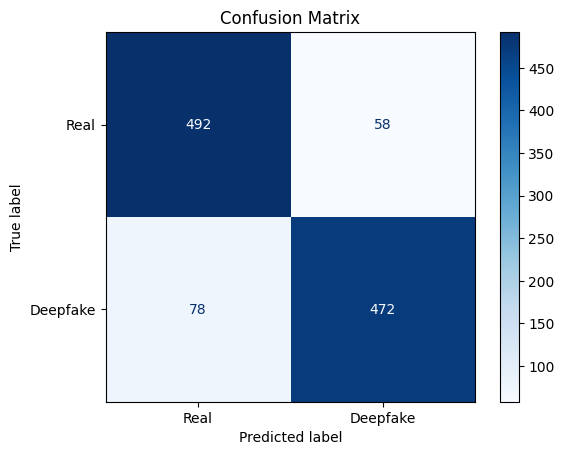

              precision    recall  f1-score   support

        Real       0.86      0.89      0.88       550
    Deepfake       0.89      0.86      0.87       550

    accuracy                           0.88      1100
   macro avg       0.88      0.88      0.88      1100
weighted avg       0.88      0.88      0.88      1100



<Figure size 640x480 with 0 Axes>

In [2]:
# Load the results CSV file
results_df = pd.read_csv('results/video_classification_results.csv')

# Prepare the true labels and predicted probabilities for confusion matrix and classification report
y_true = results_df['actual_label']
y_pred_prob = results_df['predicted_probability']

# Apply threshold to create binary predictions (adjust the threshold if needed)
threshold = 0.5
y_pred_binary = [1 if prob >= threshold else 0 for prob in y_pred_prob]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Deepfake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
os.makedirs('results', exist_ok=True)
plt.savefig('results/confusion_matrix.png')

# Print classification report
print(classification_report(y_true, y_pred_binary, target_names=["Real", "Deepfake"]))

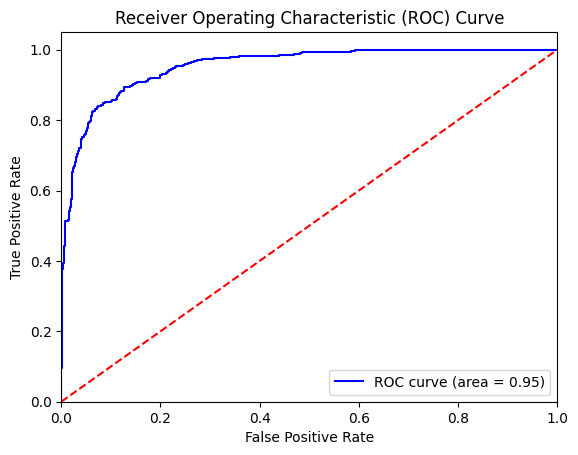

In [4]:
# Plot AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
os.makedirs('results', exist_ok=True)
plt.savefig('results/auc_roc.png')